In [1]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,matthews_corrcoef

from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
transactions = pd.read_csv("../data/transactions_train.csv")
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


#### Correlation Matrix on Balanced Dataset

Distribution of the classes in the Balanced dataset
1    0.5
0    0.5
Name: isFraud, dtype: float64


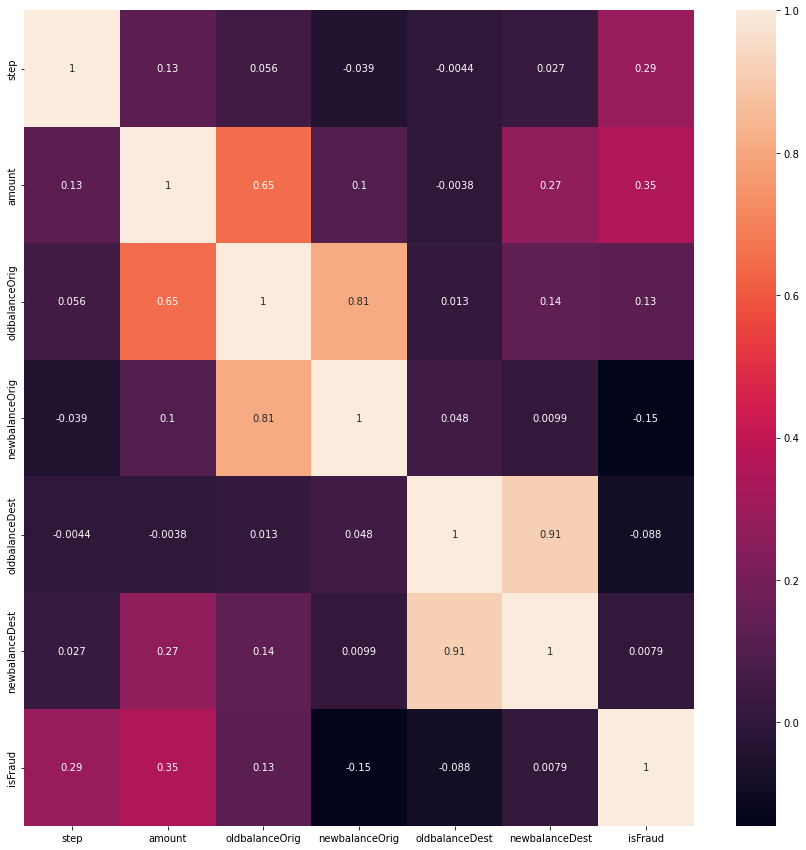

In [3]:
df = transactions.sample(frac=1)
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:len(fraud_df)]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1)

print("Distribution of the classes in the Balanced dataset")
print(new_df["isFraud"].value_counts()/len(new_df))
plt.figure(figsize=(15,15))
g = sns.heatmap(new_df.corr(), annot=True)

### Train-test split

In [4]:
transactions = pd.read_csv("../data/transactions_train.csv")
X = transactions[["type", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
Y = transactions["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print("y_train Fraud: {:.2f}%".format(y_train.value_counts()[0]/len(y_train)*100))
print("y_train Non-fraud: {:.2f}%".format(y_train.value_counts()[1]/len(y_train)*100))
print("y_test Fraud: {:.2f}%".format(y_test.value_counts()[0]/len(y_test)*100))
print("y_test Non-fraud: {:.2f}%".format(y_test.value_counts()[1]/len(y_test)*100))

y_train Fraud: 99.88%
y_train Non-fraud: 0.12%
y_test Fraud: 99.88%
y_test Non-fraud: 0.12%


In [ ]:
kf = KFold(n_splits=10, shuffle=True)

results_list = {
    "Fold": [],
    "Accuracy": [],
    "F1-Score": [],
    "MCC": [],
    "TP": [],
    "FP": [],
    "FN": [],
    "TN": [],
}

fold = 0
for train_index, test_index in kf.split(X_train):
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Encode types
    type_encoder = LabelEncoder()
    type_names = X_train_split["type"].unique()
    type_encoder.fit(type_names)
    type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")
    X_train_split["type"] = type_encoder.transform(X_train_split["type"])
    
    # Normalize
    scaler = StandardScaler()
    X_train_split = scaler.fit_transform(X_train_split)
    
    print("Distribution of y_train set BEFORE balancing: {}", Counter(y_train_split))
    
    under = RandomUnderSampler(sampling_strategy=0.002)
    X_train_split, y_train_split = under.fit_resample(X_train_split, y_train_split)
    
    print("Distribution of y_train set AFTER balancing: {}", Counter(y_train_split))
    
    # model = LogisticRegression()
    model = MLPClassifier(hidden_layer_sizes=(256,256,256,256,128,128,1), max_iter=50, alpha=1e-5, solver='adam')
    model = model.fit(X_train_split, y_train_split)
    
    # Encode type
    X_test_split.loc[~X_test_split.type.isin(type_encoder.classes_), 'type'] = "<unknown>"
    X_test_split["type"] = type_encoder.transform(X_test_split["type"])
    
    X_test_split = scaler.transform(X_test_split)
    predictions = model.predict(X_test_split)
    
    f1score = f1_score(y_test_split, predictions).round(4)
    accuracy = accuracy_score(y_test_split, predictions).round(4)
    mcc  = matthews_corrcoef(y_test_split,predictions).round(4)
    tn, fp, fn, tp = confusion_matrix(y_test_split, predictions).ravel()
    
    results_list["Fold"].append(fold)
    
    results_list["Accuracy"].append(accuracy)
    results_list["F1-Score"].append(f1score)
    results_list["MCC"].append(mcc)
    results_list["TP"].append(tp)
    results_list["FP"].append(fp)
    results_list["FN"].append(fn)
    results_list["TN"].append(tn)
    
    fold += 1

results_df = pd.DataFrame(results_list)
results_df

Distribution of y_train set BEFORE balancing: {} Counter({0: 4567277, 1: 5581})
Distribution of y_train set AFTER balancing: {} Counter({0: 2790500, 1: 5581})


In [ ]:
res = pd.melt(results_df, var_name='metric', value_vars=['Accuracy', 'F1-Score'])
g = sns.boxplot(x="metric", y="value", data=res, palette="Set3")
plt.title('Comparison of Model by Classification Metric')
plt.show()

### Evaluate

In [ ]:
# Encode test types
X_test.loc[~X_test.type.isin(type_encoder.classes_), 'type'] = "<unknown>"
X_test["type"] = type_encoder.transform(X_test["type"])

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
predictions = model.predict(X_test)

f1score = f1_score(y_test, predictions).round(4)
accuracy = accuracy_score(y_test, predictions).round(4)
mcc = matthews_corrcoef(y_test,predictions).round(4)
cm = confusion_matrix(y_test,predictions)

print("F1Score: {}".format(f1score))
print("Accuracy: {}".format(accuracy))

cmtx = pd.DataFrame(cm, index=['True (Y)', 'True (N)'], columns=['Prediction (Y)', 'Prediction: (N)'])
cmtx

### Store Artifacts

In [ ]:
def dump_artifact(artifact, artifact_path):
    with open(artifact_path, 'wb') as handle:
        pickle.dump(artifact, handle, protocol=pickle.HIGHEST_PROTOCOL)

artifacts = {
    "type_encoder": type_encoder,
    "model": model,
    "scaler": scaler
}
dump_artifact(artifacts, "../MLP_saved_models/balanced_MLP.pkl")